In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
#    Define your Dataset    
sADF=pd.read_csv(r"Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [33]:
# ++++++++++++++++++ This part has contains all the necessary functions  +++++++++++++
# The following function identifies all the rains events,
#  and wellflood duration and drawdown durations, levels & rates within each event
def IdentifyEvents(df,dry_hours_skip,w,lambda_S,lambda_E,lambda_k):
    #  This method use moving STD (std_mov) (last (moving_hours) hours) for start and end of an event
    # For the start of an event use: std_mov > lambda_S percent of range of std_mov 
    # To detect the end of an event use: std_mov < lambda_E percentage of range of std_mov
    
    skip=int(dry_hours_skip*(60/5))    # (dry_hours_skip) hours of no significant change in water level means start of another event
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    
    # +++++++++++ this part calculates the moving STD  ++++++++++
    
    std_mov=moving_std(df,w)      # calculates STD of last (moving_hours) hours
    
    # This part set the threshold for START and END of an event
    thres_E=np.max(std_mov)*lambda_E            # lambda_E percent of the range of moving STD
    thres_S=np.max(std_mov)*lambda_S        # lambda_S percent of the range of moving STD
    
    
    
    # ++++++++++++++++ This part identify the rainfall events  ++++++++++++++++
    
    nre=True     #indicator if the current time falls under "No Rain Event" or not
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    i=1
    while i<df.shape[0]-1:
        if std_mov[i]>=thres_S:
            if nre==True:
                # This is a new rainfall event
                start_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                start_index.append(df.index.to_list()[0]+i)
                nre=False
                i+=1
            while std_mov[i]>thres_E:
                i+=1
            if np.max(std_mov[i+1:i+skip+1])<thres_S:
                # dry period starts from index i+1
                end_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                end_index.append(df.index.to_list()[0]+i)
                nre=True
                i=i+skip
        i+=1
    
    # ++++++++++++++ This part finds wellflood duration and drawdown rates +++++++++++++
    
    wf_d=[]      # Wellflood duration for an event
    max_wl=[]    # Max water level
    dd_d=[]      # drawdown durations
    dd_l=[]      # drawdown levels
    dd_r=[]      # drawdown rates
    dd_r_ave=[]  # average drawdown rate within an event
    for event in range(np.size(start_index)):
        wfd,e_dd,e_dl,e_dr,start,end=drawdown_wellflood_event(df,wl_mm,event,start_index,end_index,lambda_k)
        wf_d.append(wfd)
        max_wl.append(np.max(wl_mm[start_index[event]:end_index[event]+1]))    # max water level for each event
        dd_r_ave.append(np.average(e_dr))
        dd_d=np.append(dd_d,e_dd)
        dd_l=np.append(dd_l,e_dl)
        dd_r=np.append(dd_r,e_dr)
        #print(np.size(dd_r))  
    return start_time,end_time,start_index,end_index,np.subtract(end_index,start_index),max_wl,wf_d,dd_r_ave,dd_r,wl_mm,thres_S,thres_E

# following function identifies wellflood duration and drawdown durations, levels & rates within an event
def drawdown_wellflood_event(df,wlevel_mm,index,start_index,end_index,lambda_k):
    #index=i
    max_mov=moving_max(df[start_index[index]:end_index[index]],0.5)  #moving max of last 30 minutes
    wl=wlevel_mm[start_index[index]:end_index[index]+1]
    
    # ++++++  Wellflood Duration within an event  ++++++
    
    # Well flood happens when water level is above lambda_k% of min waterlevel within an event
    lambda_k=0.05
    c=0
    for j in wl:
        if j>=np.min(wl)+(np.max(wl)-np.min(wl))*lambda_k:     
            c+=1
    wfd=c*(5/60)     #converted into hours
    
    # ++++++++++  finding peak and bottom from an event (there could be multiple drawdowns) ++++++++
    
    start=[]
    end=[]
    i=1
    while i <np.size(wl)-1:
        if max_mov[i]-wl[i]>0:
            start.append(i-1)
            while max_mov[i]-wl[i]>0:
                i+=1
                if i>=np.size(wl):
                    break
            end.append(i-1)
        i+=1
    # Discards peaks that's have very small amount of drawdown
    i=0
    while i<np.size(start)-1:
        if abs(wl[start[i]]-wl[end[i]])<150:
            if wl[start[i]]<wl[start[i+1]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1
    i=0
    while i<np.size(start)-1:  
        if abs(wl[end[i]]-wl[start[i+1]])<150:
            end.pop(i)
            start.pop(i+1)
            continue
        else:
            i+=1
    # Discard peaks which are very close to each other
    i=0
    while i<np.size(start)-1:
        if (start[i+1]-start[i])<25:
            if wl[start[i+1]]>wl[start[i]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1
            
    # +++++++++++ calculates all the drawdown durations, levels and rates within an event +++++++++++
    
    e_dd=[]    # drawdown durations
    e_dl=[]    # drawdown levels
    e_dr=[]    # drawdown rates
    for j in range(np.size(start)):
            dd=((end[j]-start[j])*5)/60        # converted into hours
            dl=wl[start[j]]-wl[end[j]]    #measured in mm
            dr=dl/dd                      #Measured in mm/hour
            e_dd.append(dd)
            e_dl.append(dl)
            e_dr.append(dr)
    return wfd,e_dd,e_dl,e_dr,start,end

# Calculate moving STD of last *few hours
def moving_std(df,period_in_hour):      
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_std=[0]
    mean_mov=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_std.append(np.std(wl_mm[:i+1]))
            mean_mov.append(np.mean(wl_mm[:i+1]))
        else:
            mov_std.append(np.std(wl_mm[i-periods:i+1]))
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
    return mov_std

# Calculate moving MAX of last *few hours
def moving_max(df,period_in_hour):
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_max=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_max.append(np.max(wl_mm[:i+1]))
        else:
            mov_max.append(np.max(wl_mm[i-periods:i+1]))
    return mov_max


/Users/mdhasibuddinmolla/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/mdhasibuddinmolla/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


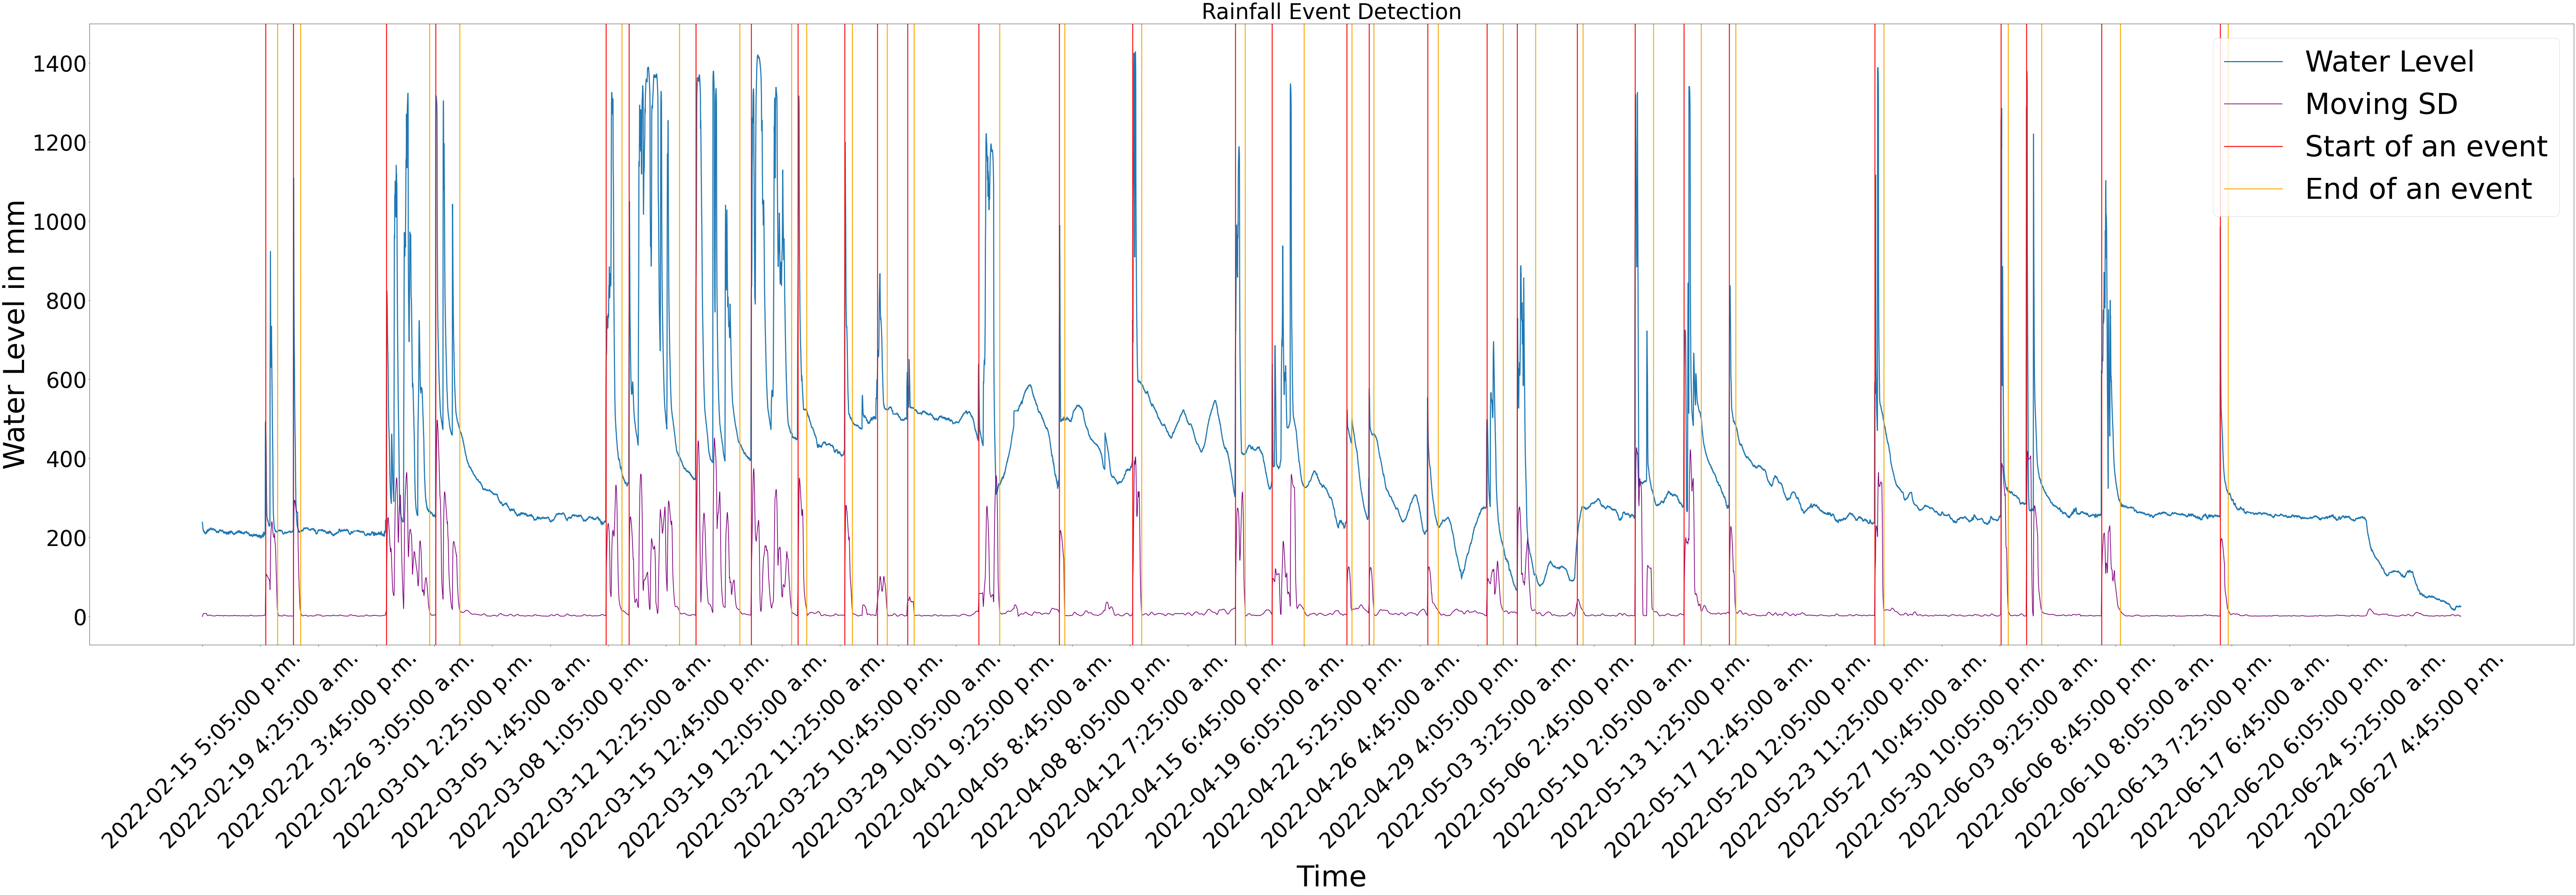

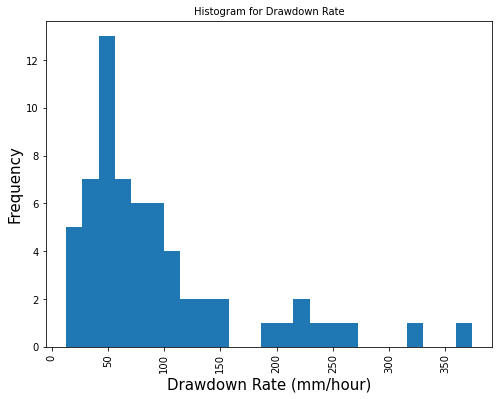

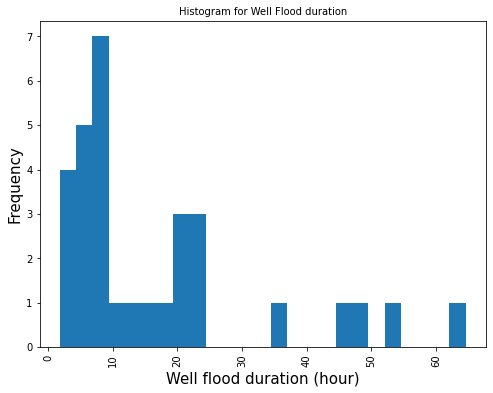

Rainfall_start_time         Rainfall_end_time  Rainfall_start_index  \
0   2022-02-19 11:50:00 a.m.   2022-02-20 5:05:00 a.m.                  1089   
1    2022-02-21 4:05:00 a.m.   2022-02-21 2:05:00 p.m.                  1572   
2    2022-02-26 5:45:00 p.m.   2022-03-01 7:25:00 a.m.                  3176   
3    2022-03-01 4:35:00 p.m.   2022-03-03 3:10:00 a.m.                  4026   
4    2022-03-11 9:15:00 p.m.   2022-03-12 7:55:00 p.m.                  6962   
5    2022-03-13 7:20:00 a.m.   2022-03-16 7:25:00 a.m.                  7359   
6    2022-03-17 7:20:00 a.m.  2022-03-19 10:30:00 p.m.                  8511   
7    2022-03-20 2:50:00 p.m.   2022-03-23 1:00:00 a.m.                  9465   
8    2022-03-23 9:55:00 a.m.  2022-03-23 10:40:00 p.m.                 10270   
9    2022-03-26 5:25:00 a.m.   2022-03-26 4:15:00 p.m.                 11080   
10   2022-03-28 4:30:00 a.m.   2022-03-28 6:15:00 p.m.                 11645   
11  2022-03-29 11:40:00 p.m.   2022-03-30 8:45:00 a.m.                 12163   
12   2022-04-03 5:50:00 a.m.  2022-04-04 11:55:00 a.m.                 13389   
13   2022-04-08 1:45:00 a.m.   2022-04-08 9:25:00 a.m.                 14780   
14  2022-04-12 11:10:00 a.m.  2022-04-12 11:50:00 p.m.                 16045   
15   2022-04-18 2:50:00 p.m.   2022-04-19 4:55:00 a.m.                 17817   
16   2022-04-20 7:40:00 p.m.   2022-04-22 5:40:00 p.m.                 18451   
17   2022-04-25 7:05:00 a.m.   2022-04-25 1:55:00 p.m.                 19740   
18   2022-04-26 3:00:00 p.m.   2022-04-26 9:50:00 p.m.                 20123   
19   2022-04-30 2:55:00 a.m.   2022-04-30 6:15:00 p.m.                 21130   
20   2022-05-03 4:10:00 p.m.   2022-05-04 3:45:00 p.m.                 22153   
21  2022-05-05 12:00:00 p.m.   2022-05-06 2:00:00 p.m.                 22679   
22   2022-05-09 2:10:00 a.m.  2022-05-09 10:15:00 a.m.                 23713   
23   2022-05-12 1:00:00 p.m.   2022-05-13 3:30:00 p.m.                 24707   
24  2022-05-15 11:35:00 a.m.  2022-05-16 12:00:00 p.m.                 25554   
25   2022-05-18 4:40:00 a.m.   2022-05-18 1:55:00 p.m.                 26335   
26   2022-05-26 9:35:00 p.m.  2022-05-27 10:50:00 a.m.                 28842   
27  2022-06-03 10:55:00 a.m.   2022-06-03 9:35:00 p.m.                 31018   
28  2022-06-04 11:30:00 p.m.   2022-06-05 9:30:00 p.m.                 31457   
29  2022-06-09 11:30:00 a.m.   2022-06-10 2:30:00 p.m.                 32753   
30   2022-06-16 2:15:00 p.m.   2022-06-17 1:45:00 a.m.                 34802   

    Rainfall_end_index  Rainfall_duration (periods)  Max WaterLevel(mm)  \
0                 1296                          207               923.0   
1                 1692                          120              1109.0   
2                 3916                          740              1323.0   
3                 4441                          415              1316.0   
4                 7234                          272              1325.0   
5                 8224                          865              1389.0   
6                 9269                          758              1379.0   
7                10163                          698              1420.0   
8                10423                          153              1316.0   
9                11210                          130              1199.0   
10               11810                          165               867.0   
11               12272                          109               650.0   
12               13750                          361              1221.0   
13               14872                           92               989.0   
14               16197                          152              1428.0   
15               17986                          169              1188.0   
16               19003                          552              1347.0   
17               19822                           82               523.0   
18               20205 

In [34]:
#  ------------------- This is the result generation section -----------------------------

#  ++++++++++++++++++++++  Enter the Name of Your Dataset Below +++++++++++++++++++++++++
dataset=sADF

#  +++++++++++++   Choose the value of your parameters
# parmeters {w, lambda_S, lambda_E, lambda_k} are used from the methodology section of the report
dry_hours_to_skip=6        # in hours
w=6                        # in hours
lambda_S=7.5/100
lambda_E=3/100
lambda_k=0.05



pd.to_datetime(dataset["Timestamp"]);

# This part calculate all rainfall events
start_time,end_time,start_index,end_index,rf_duration,max_wl,wflood_d,drawdownR_ave,drawdown_rates,water_level,startp,endp=IdentifyEvents(dataset,dry_hours_to_skip,w,lambda_S,lambda_E,lambda_k)
rf_event=pd.DataFrame({"Rainfall_start_time":start_time,"Rainfall_end_time":end_time,"Rainfall_start_index":start_index,"Rainfall_end_index":end_index,"Rainfall_duration (periods)":rf_duration,"Max WaterLevel(mm)":max_wl,"WellFlood_duration (hours)":wflood_d,"Avg. Drawdown Rate(mm/hour)":drawdownR_ave})



# This draw all data set with events being identified
fig=plt.figure(figsize=(120, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level),1000)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level),1000)])

wle,=plt.plot(water_level,label='Water Level',linewidth=3)
std_mov=moving_std(dataset,w)
mstd,=plt.plot(std_mov,label="Moving SD",linewidth=2,color="purple")
for i in start_index:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_index:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.xlabel('Time',fontsize=80)
plt.ylabel('Water Level in mm',fontsize=80)
plt.tick_params(axis='x',labelsize=60,rotation=45)
plt.tick_params(axis='y',labelsize=60)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=80)
plt.title("Rainfall Event Detection",fontsize=60)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(drawdown_rates,bins=25)
plt.xlabel('Drawdown Rate (mm/hour)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.tick_params(axis='x',labelsize=10,rotation=90)
plt.tick_params(axis='y',labelsize=10)
plt.title("Histogram for Drawdown Rate",fontsize=10)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(wflood_d,bins=25)
plt.xlabel("Well flood duration (hour)",fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.tick_params(axis='x',labelsize=10,rotation=90)
plt.tick_params(axis='y',labelsize=10)
plt.title("Histogram for Well Flood duration",fontsize=10)
plt.show()


rf_event

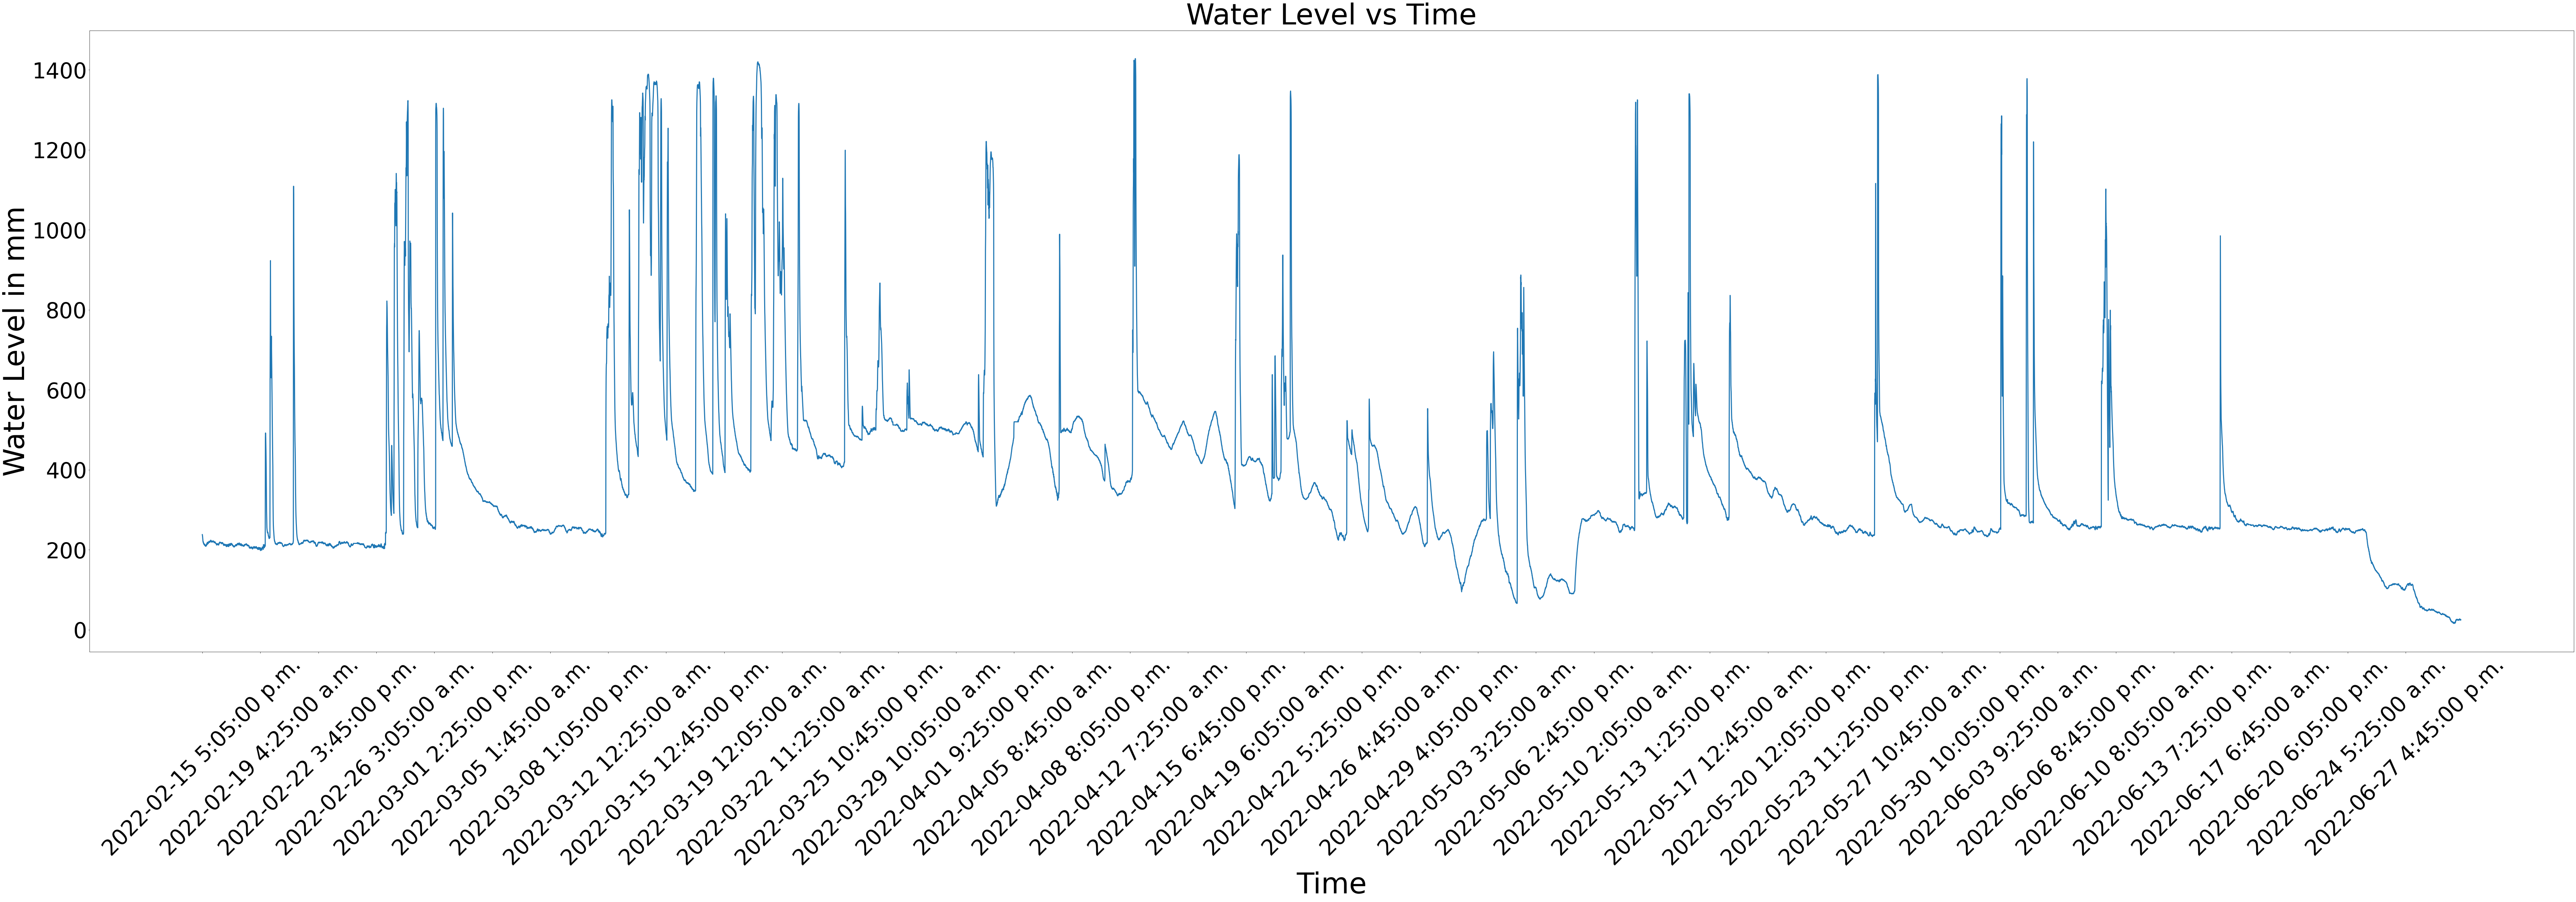

In [35]:
# This part draws the whole water level data
fig=plt.figure(figsize=(120, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level),1000)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level),1000)])

plt.plot(water_level,label='Water Level',linewidth=3)
plt.xlabel('Time',fontsize=80)
plt.ylabel('Water Level in mm',fontsize=80)
plt.tick_params(axis='x',labelsize=60,rotation=45)
plt.tick_params(axis='y',labelsize=60)
plt.title("Water Level vs Time",fontsize=80)
plt.show()

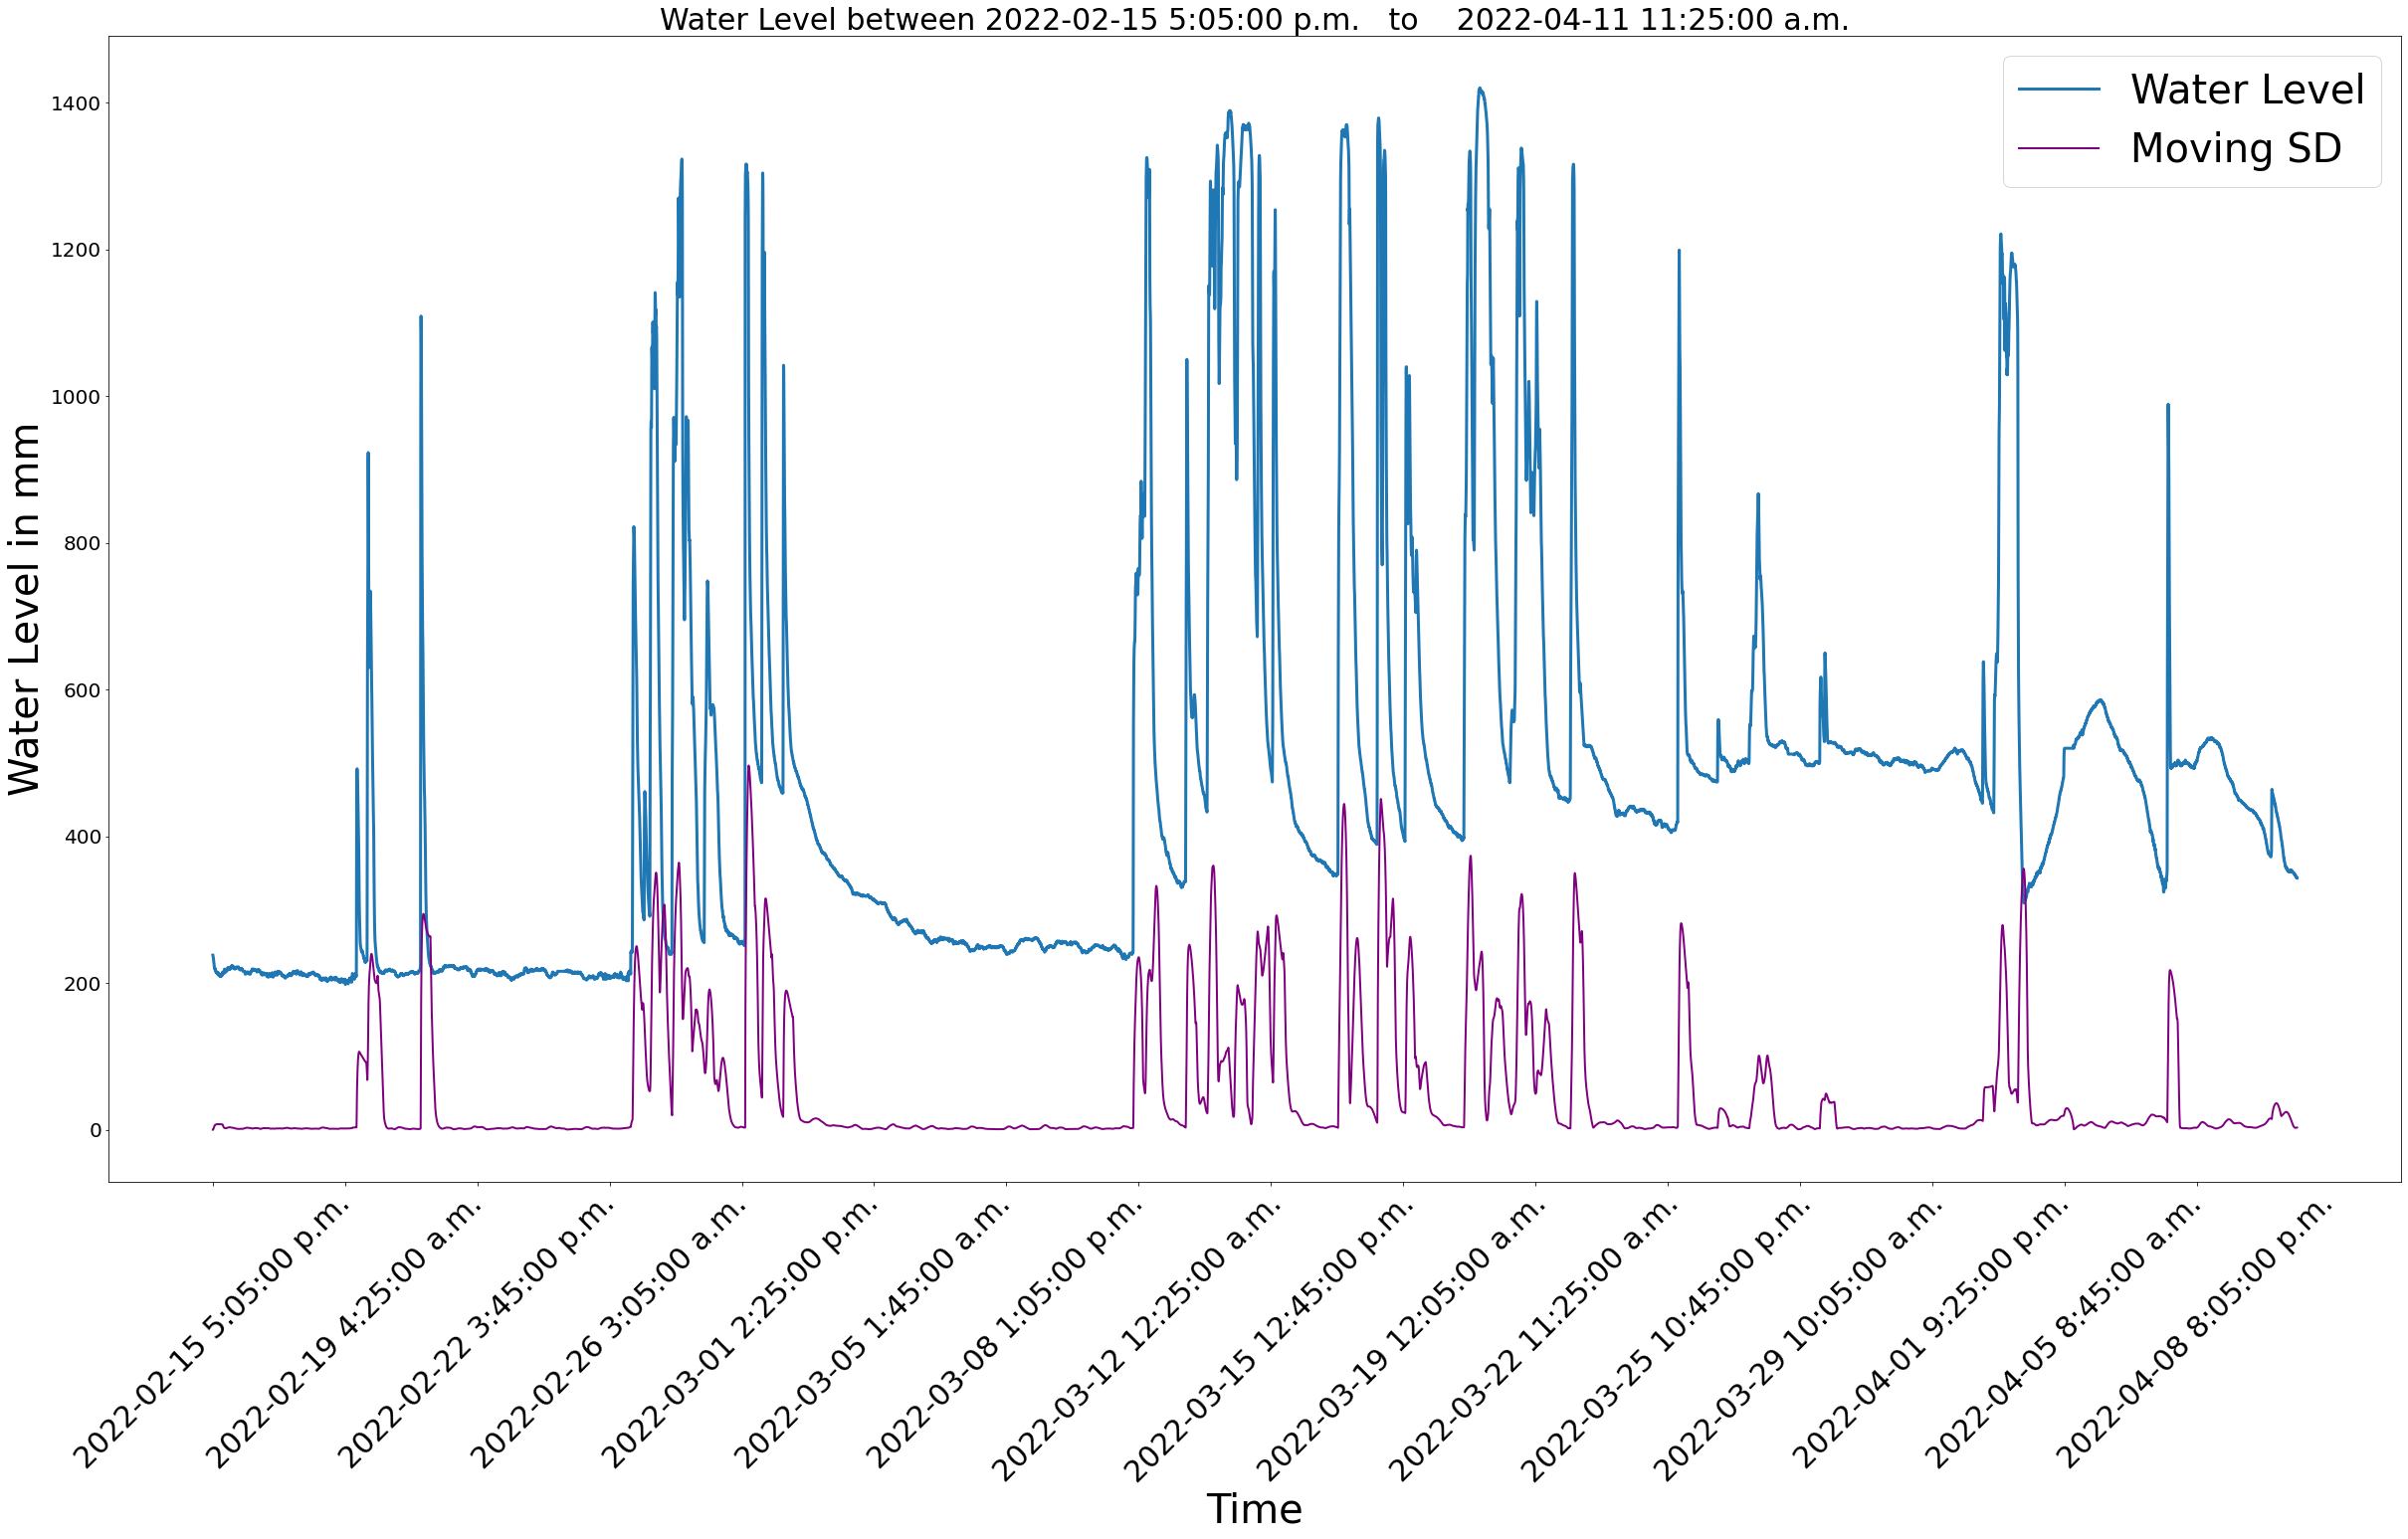

In [36]:
# This draw (Partial) data set with Moving SD
length=15760
fig=plt.figure(figsize=(40, 20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level[:length]),1000)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level[:length]),1000)])

wle,=plt.plot(water_level[:length],label='Water Level',linewidth=3)
#plt.plot(mean_mov)
std_mov=moving_std(dataset,w)
mstd,=plt.plot(std_mov[:length],label="Moving SD",linewidth=2,color="purple")
plt.xlabel('Time',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=45)
plt.tick_params(axis='y',labelsize=20)
plt.legend(loc = 'best',handles=[wle,mstd],fontsize=40)
plt.title("Water Level between "+dataset["Timestamp"][0]+"   to    "+dataset["Timestamp"][length],fontsize=30)
#plt.title("Water Level with moving SD",fontsize=30)
plt.show()

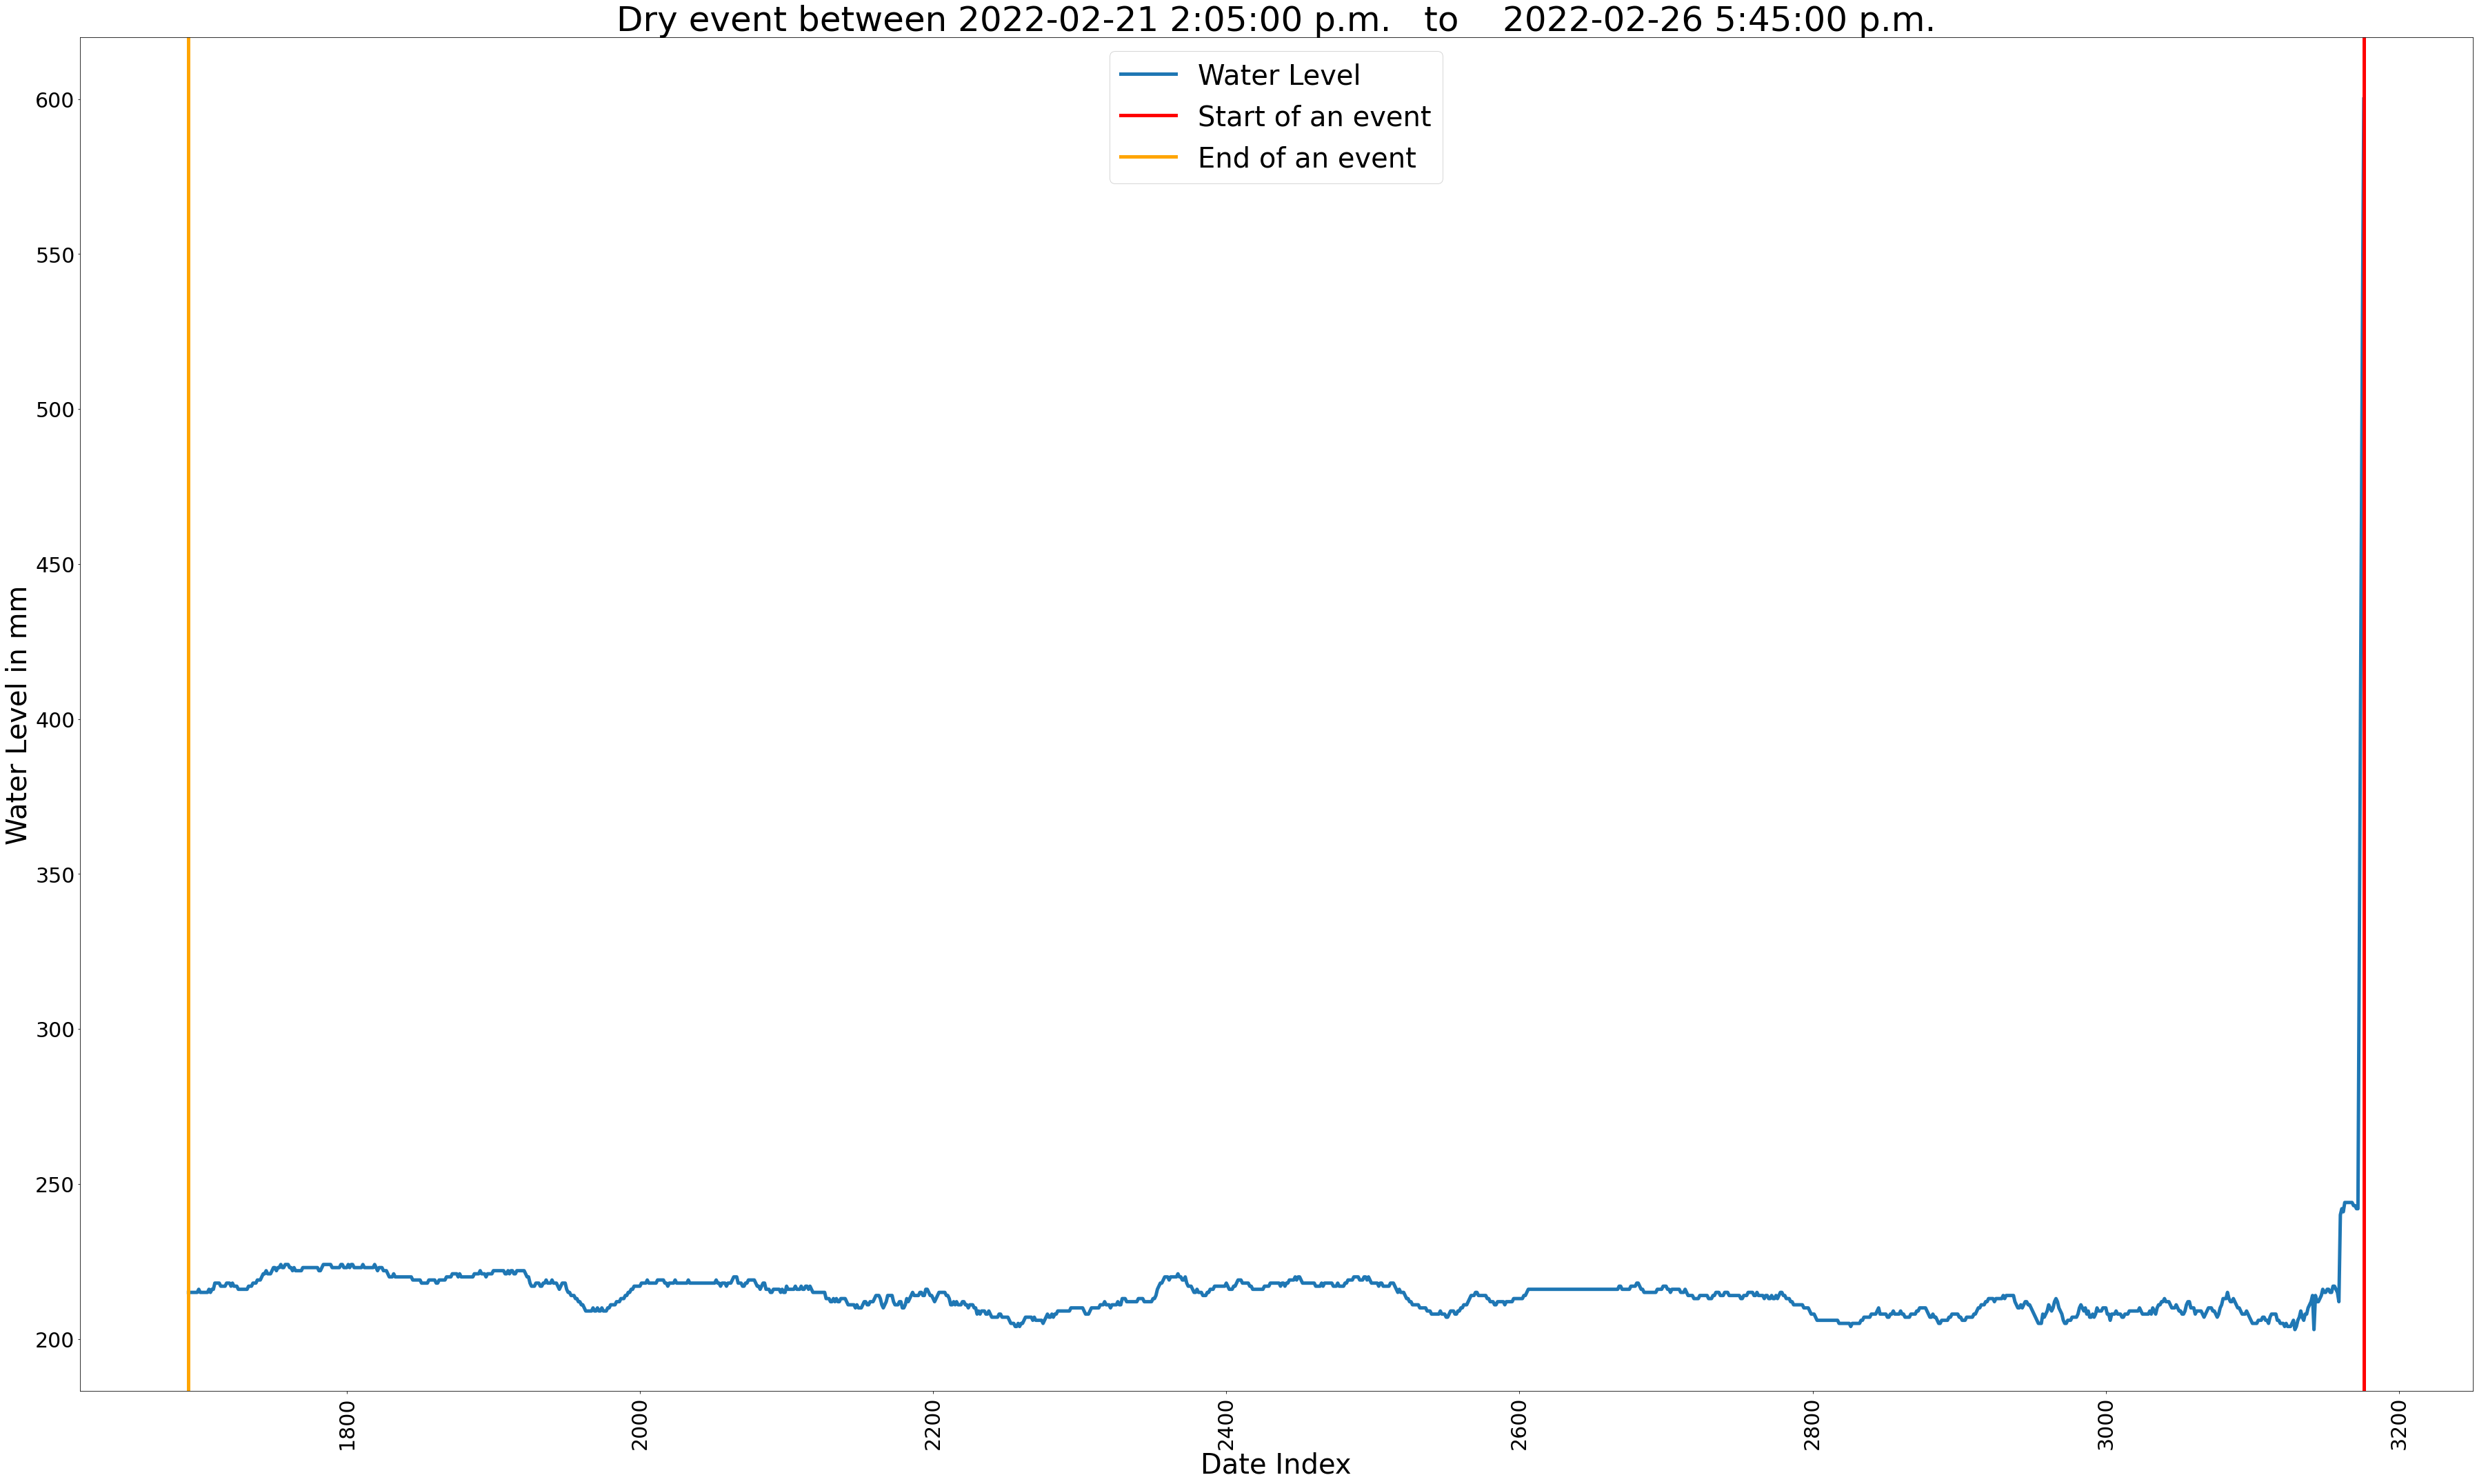

In [37]:
# Let's look at a particular No !Rainfall event
buffer=0
index=2
X=range(end_index[index-1]-buffer,start_index[index]+buffer+1)
Y=water_level[rf_event["Rainfall_end_index"][index-1]-buffer:rf_event["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_index[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_index[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title("Dry event between "+end_time[index-1]+"   to    "+start_time[index],fontsize=50)
plt.tight_layout()
plt.show()

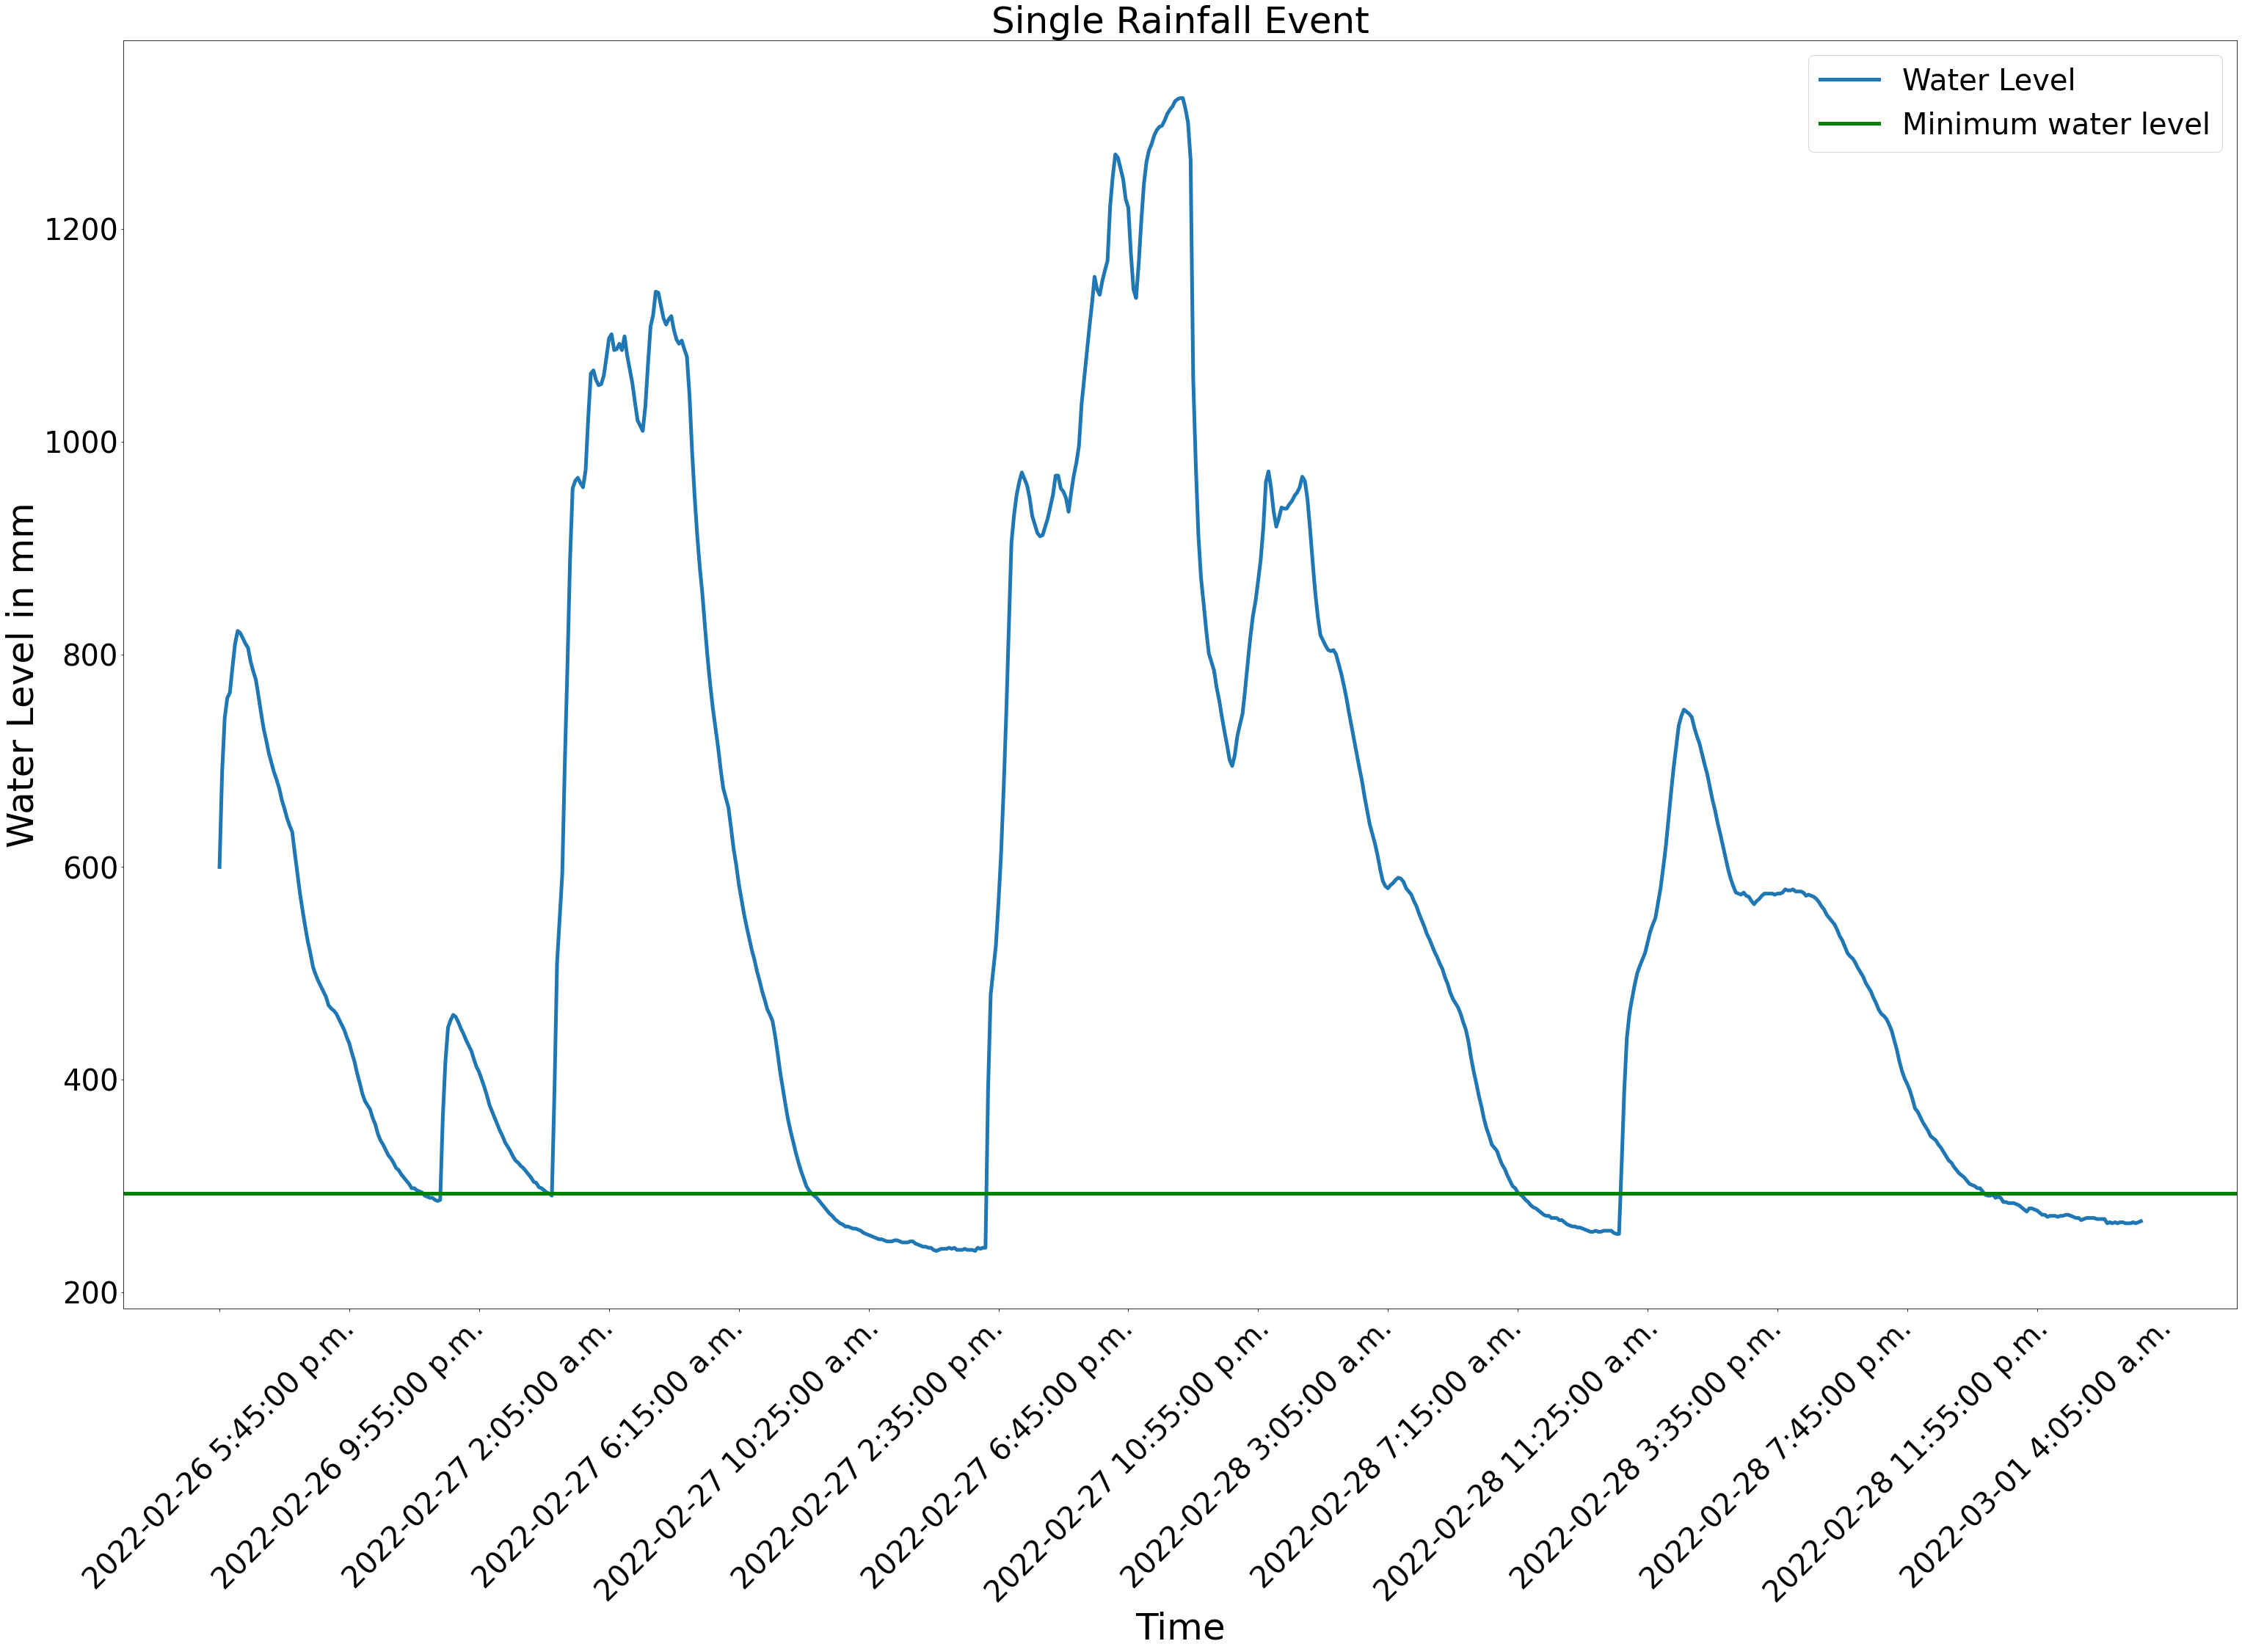

In [38]:
# Let's see a particular !Rainfall event
buffer=0
index=2
X=range(start_index[index]-buffer,end_index[index]+buffer+1)
Y=water_level[start_index[index]-buffer:end_index[index]+buffer+1]
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(start_index[index],end_index[index],50)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(start_index[index],end_index[index],50)])
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axhline(y=np.min(Y)+(np.max(Y)-np.min(Y))*0.05,color="green",label="Minimum water level",linewidth=5)
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=40)
plt.legend(loc = 'best',fontsize=40)

#plt.tight_layout()
plt.title("Single Rainfall Event",fontsize=50)
plt.show()
        

741


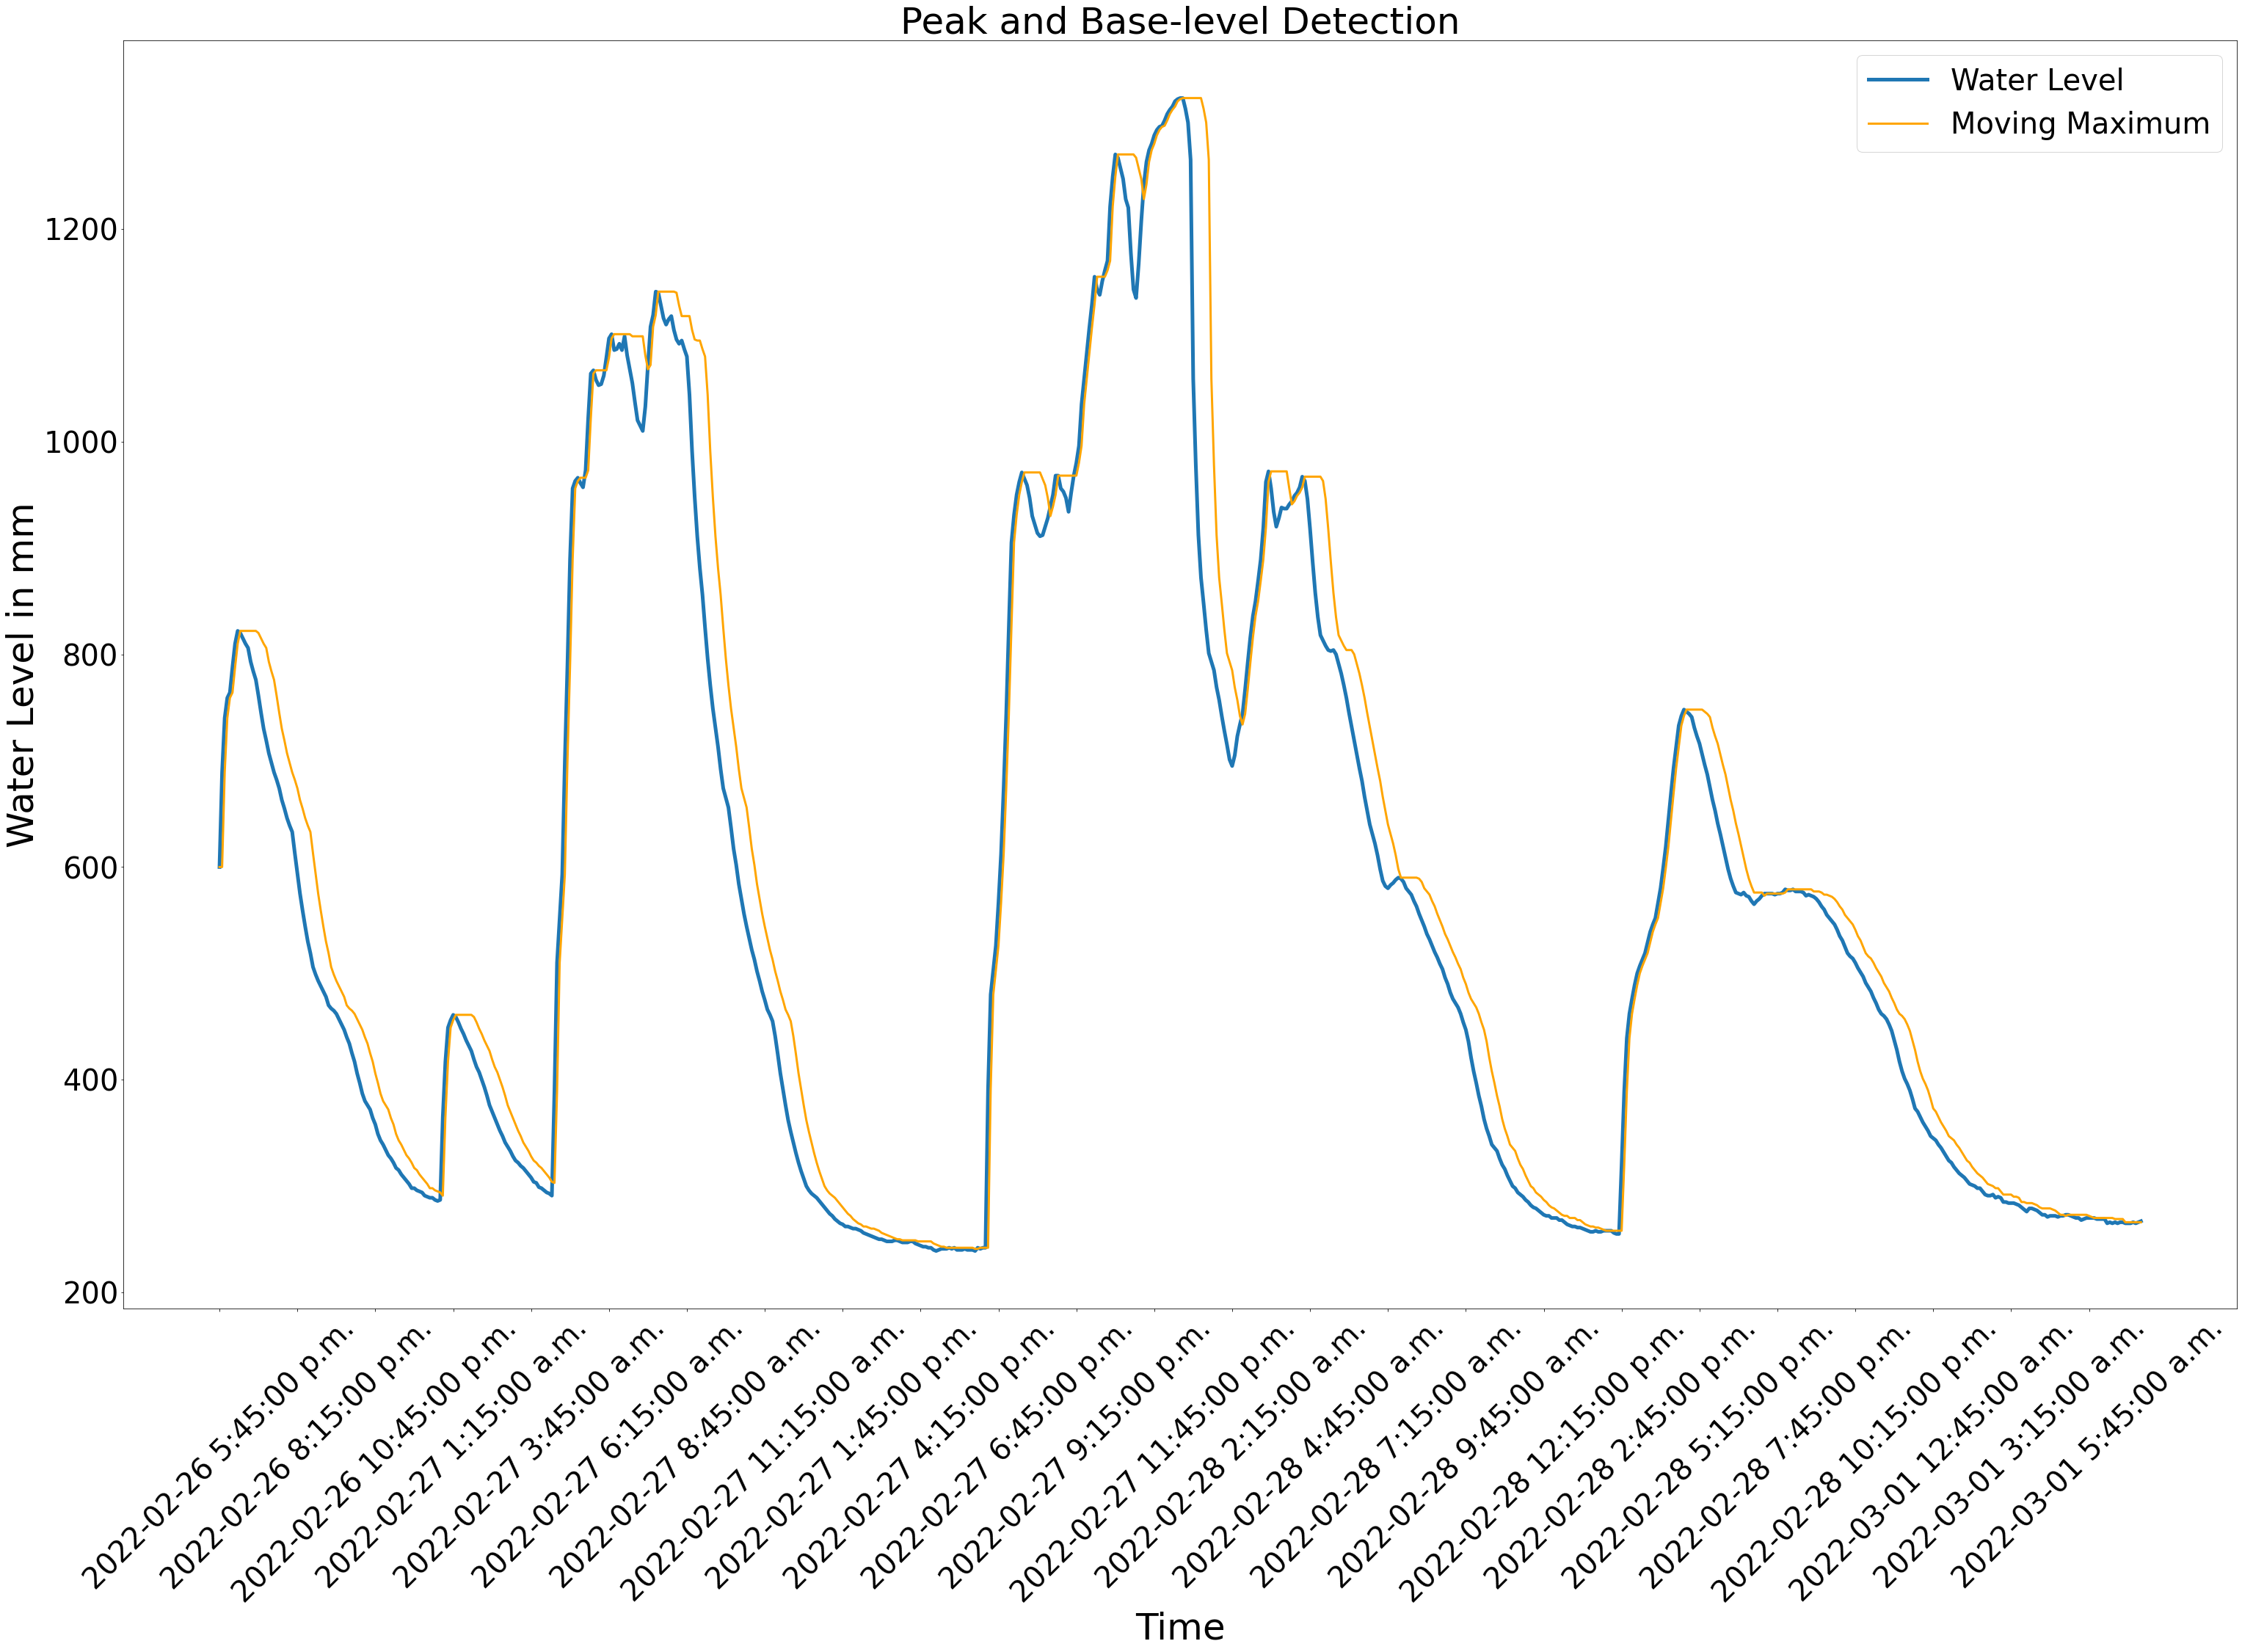

In [39]:
# This part draws a particular event with moving MAX
buffer=0
index=2
max_mov=moving_max(dataset[start_index[index]-buffer:end_index[index]+buffer],0.5)
std_mov=moving_std(dataset[start_index[index]-buffer:end_index[index]+buffer],0.5)
wl=water_level[start_index[index]-buffer:end_index[index]+buffer+1]
print(np.size(wl))
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,rf_duration[index],30)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(start_index[index],end_index[index],30)])
plt.plot(wl,linewidth=5,label="Water Level")
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=40)
plt.plot(max_mov,linewidth=3,color="orange",label="Moving Maximum")
plt.title("Peak and Base-level Detection",fontsize=50)
plt.legend(loc = 'best',fontsize=40)

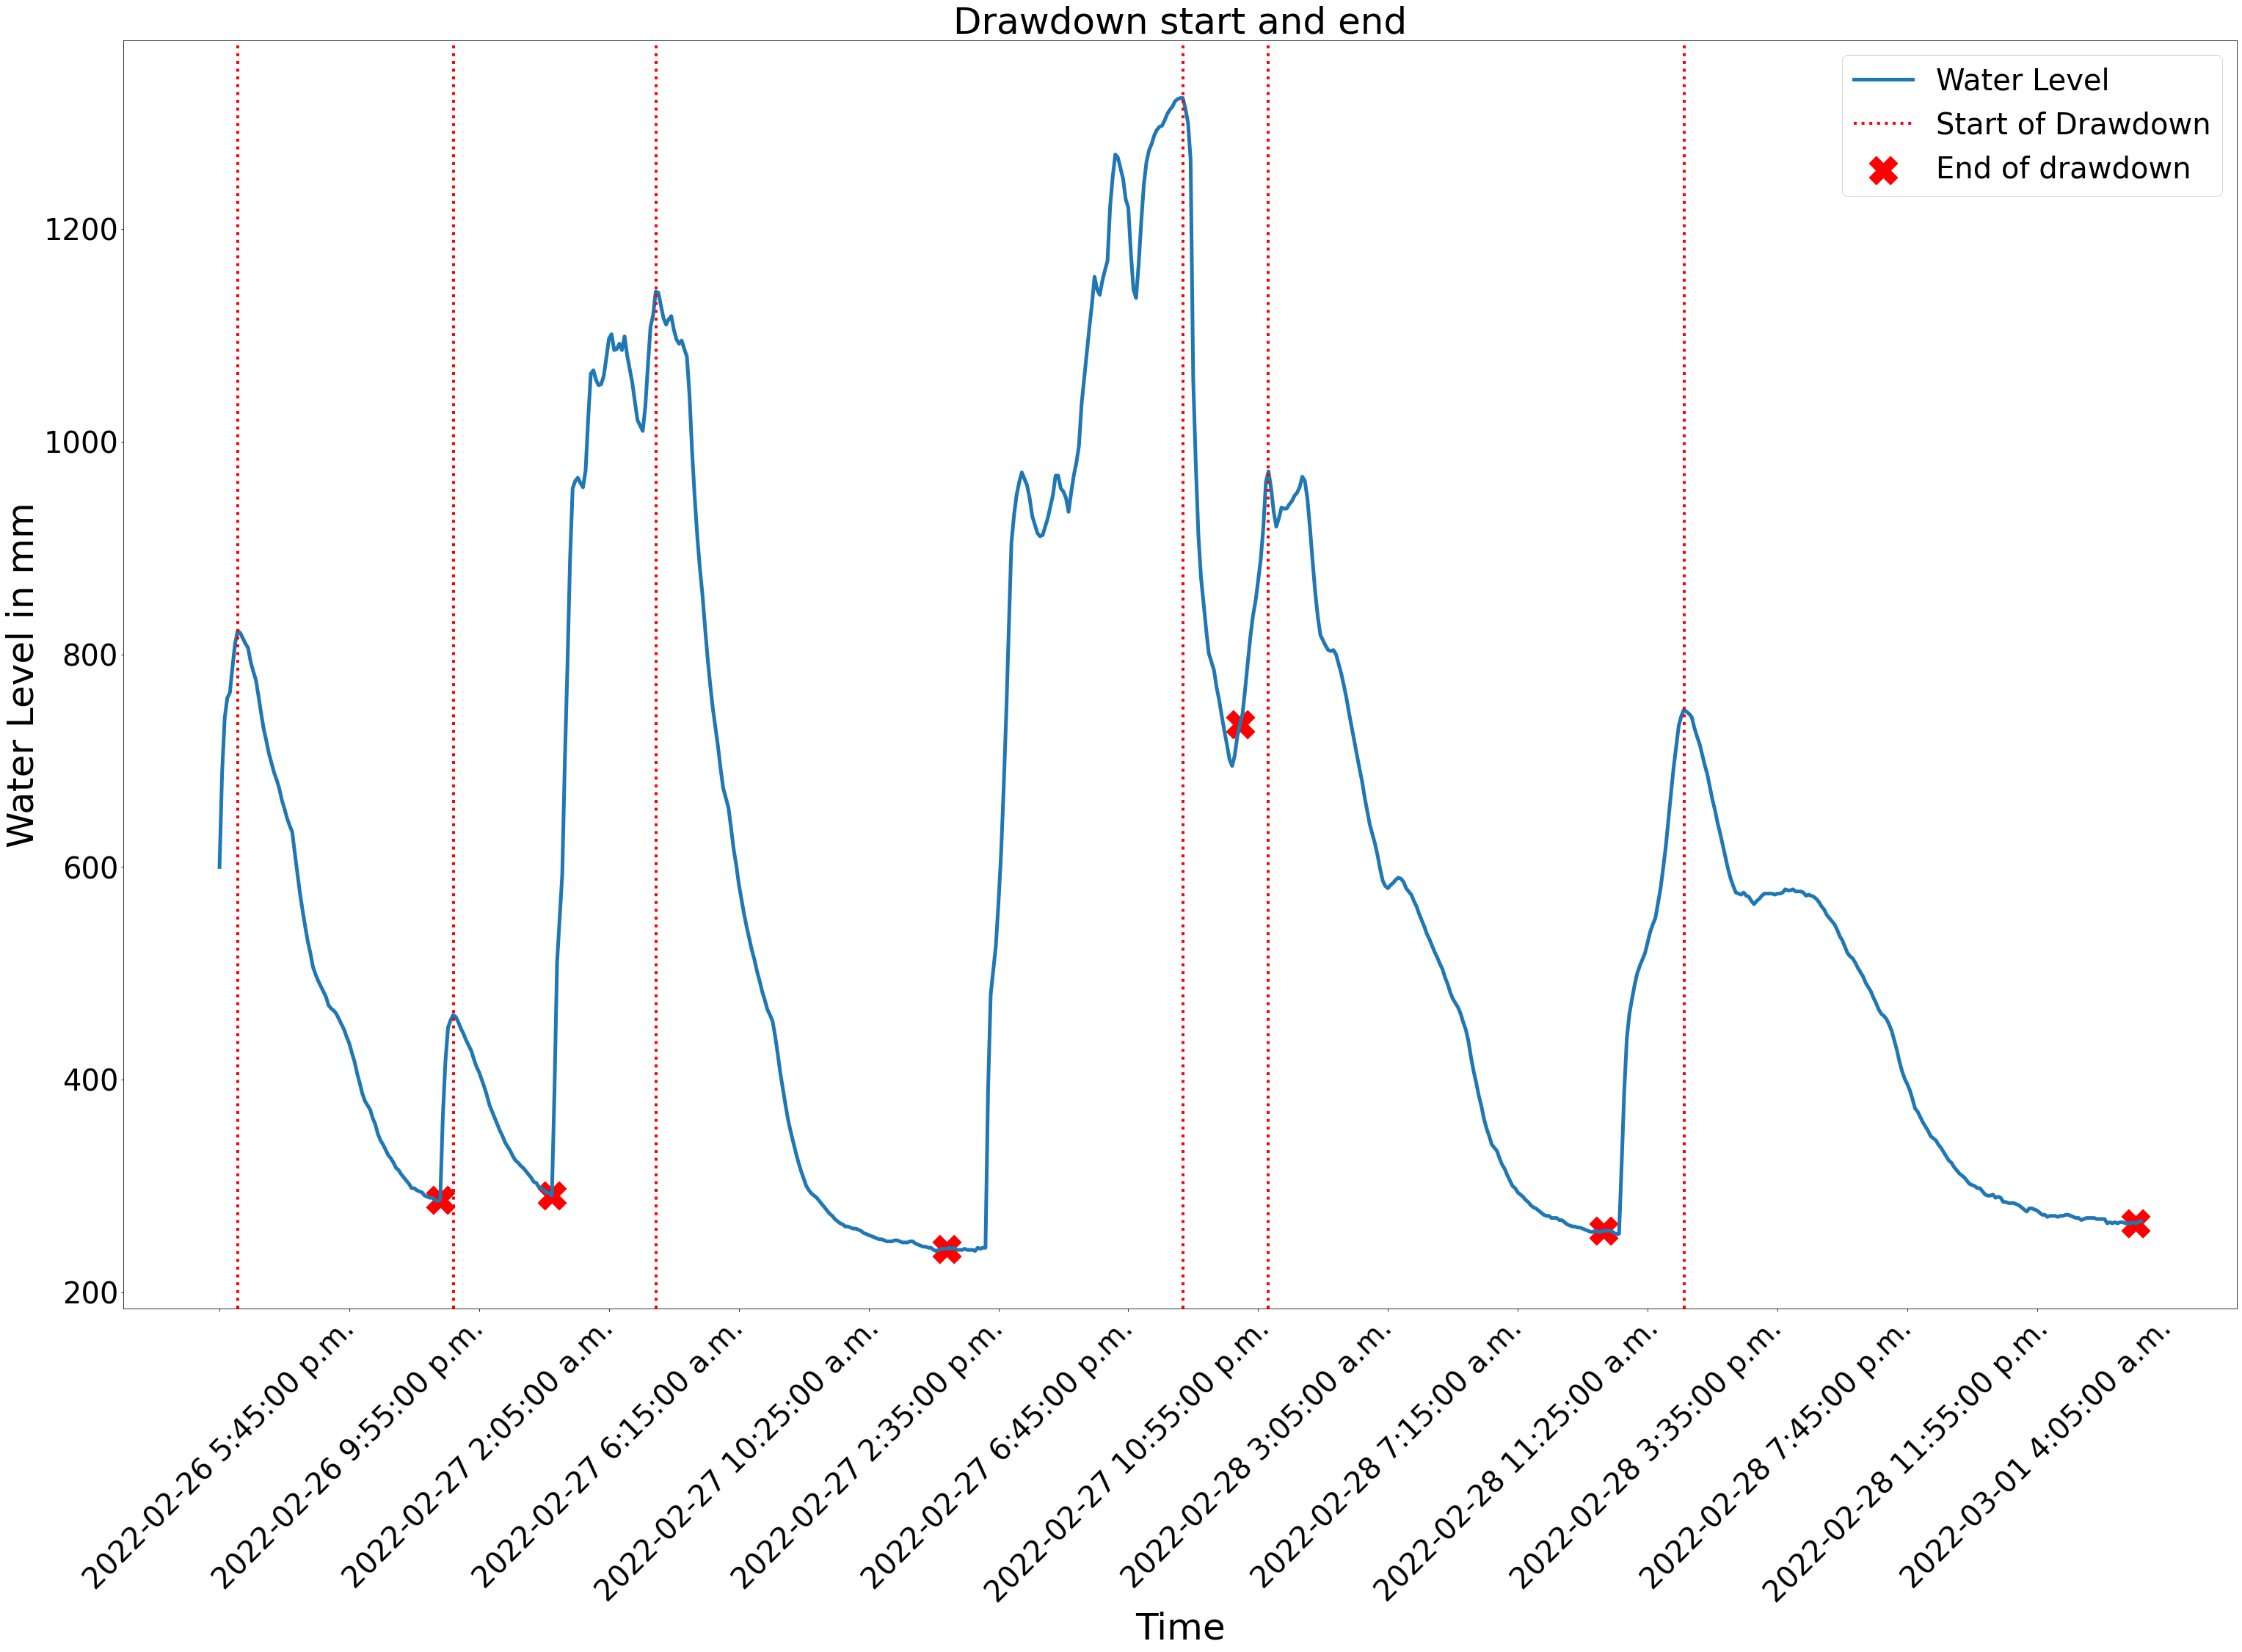

In [40]:
# This part identifies the start and ends of several drawdowns from a particular event
index=2
wfd,e_dd,e_dl,e_dr,start,end=drawdown_wellflood_event(dataset,water_level,index,start_index,end_index,lambda_k)
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,rf_duration[index],50)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(start_index[index],end_index[index],50)])
wle,=plt.plot(wl,label="Water Level",linewidth=5)
for i in start:
    st=plt.axvline(x=i, linewidth=4,color='r',linestyle="dotted",label="Start of Drawdown")
for i in end:
    en=plt.scatter(i,wl[i],s=1500,marker="X", color='red',label="End of drawdown")
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=40)
plt.legend(loc = 'best',handles=[wle,st,en],fontsize=40)
plt.title("Drawdown start and end",fontsize=50)
plt.show()